<a href="https://colab.research.google.com/github/dmartmillan/DeepLearningSpotNuclei/blob/main/template_final3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from PIL import Image
from IPython.display import Image as DPImage
import os
import numpy as np
from random import sample
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn as sk
import pandas as pd
import tensorflow as tf
from tensorflow import keras
import random
import csv
import skimage

from sklearn.model_selection import train_test_split


from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization, Activation
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Conv2DTranspose, Concatenate, UpSampling2D
from tensorflow.keras.constraints import max_norm
from tensorflow.keras.optimizers import Adam, SGD
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.models import load_model, Model
from tensorflow.keras import Input
import keras.backend as K
# from google.colab import drive
# drive.mount('/content/gdrive')
# import sys
# sys.path.insert(0,'/content/gdrive/My Drive/Colab Notebooks')
# data_loc = '/content/gdrive/My Drive/data'
data_loc = './data'
from data_processing import data_grinder

seed = 2023
np.random.seed(seed)  

Mounted at /content/gdrive


## 0. Some functions

In [2]:
def plot_history(history, steps_per_epoch = 0, y_axis_lower_bound = -1):
    
    if steps_per_epoch >0:
        xvals = int(steps_per_epoch)*np.array(history.epoch)
        xlab = 'Weight update steps'
    else:
        xvals = np.array(history.epoch)
        xlab = 'Epochs'


    plt.figure(figsize = (12,4))
    plt.subplot(1,2,1)
    plt.xlabel(xlab)
    plt.ylabel('Accuracy')
    plt.plot(xvals, np.array(history.history['mean_iou']),'g-', 
             label='Train IoU')
    plt.plot(xvals, np.array(history.history['val_mean_iou']),'r-',
             label = 'Validation IoU')
    if y_axis_lower_bound>-1:
        plt.ylim([y_axis_lower_bound,1])
    plt.legend()

    plt.subplot(1,2,2)
    plt.xlabel(xlab)
    plt.ylabel('Loss minimised by model')
    plt.plot(xvals, np.array(history.history['loss']),'g-', 
             label='Train loss')
    plt.plot(xvals, np.array(history.history['val_loss']),'r-',
             label = 'Validation loss')
    plt.legend()

def iou(y_true, y_pred):
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred), axis=[1,2,3])
        union = K.sum(y_true, axis=[1,2,3]) + K.sum(y_pred, axis=[1,2,3]) - intersection
        iou = K.mean((intersection + 1) / (union + 1), axis=0)
        return iou
def mean_iou(y_true, y_pred):
    results = []   
    for t in np.arange(0.5, 1, 0.05):
        t_y_pred = tf.cast((y_pred > t), tf.float32)
        pred = iou(y_true, t_y_pred)
        results.append(pred)
        
    return K.mean(K.stack(results), axis=0)

def diceloss(y_true, y_pred, smooth=1e-6):
    
    #flatten label and prediction tensors
        y_true = tf.cast(y_true, y_pred.dtype)
        intersection = K.sum(K.abs(y_true * y_pred))
        dice = (2*intersection + smooth) / (K.sum(y_true) + K.sum(y_pred) + smooth)
        return 1 - dice

## 1. Load images

In [3]:
import pickle
data_set = open(f'{data_loc}/data_set.obj', 'rb')
data_dict = pickle.load(data_set)
data_set.close()
train_dict = data_dict['train_dict']
val_dict = data_dict['val_dict']
test_dict = data_dict['test_dict']
data_dict.clear()

## 2. Pre-processing

### 2.1 Procedure

In [4]:
train_set = data_grinder(train_dict)
val_set = data_grinder(val_dict)
train_set.preprocessImages()
val_set.preprocessImages()

### 2.2 Displace images

Image, processed image and mask from data set No. 533 with size (360, 360): c8ca945abc29d262a5525e4c2585541bba33fa77c86a47c94575d8e5b54c83fb


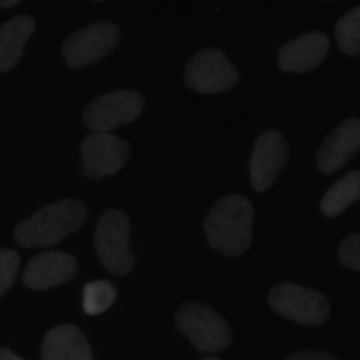

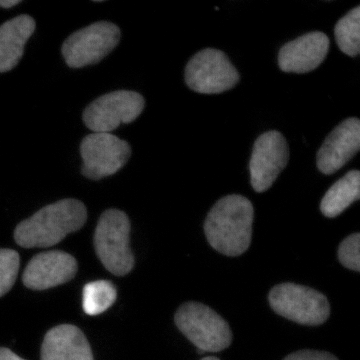

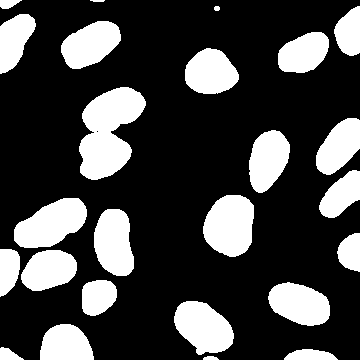

In [5]:
# display
train_set.display_imgs(ix0= 533) # without ix0 input, it will give a random index

## 3. Pre-processing

In [6]:
train_set.croporresizeImages()
val_set.croporresizeImages()

###3.2 Displace images

Processed image and mask from train set No. 82 with size (256, 256): 1e8408fbb1619e7a0bcdd0bcd21fae57e7cb1f297d4c79787a9d0f5695d77073


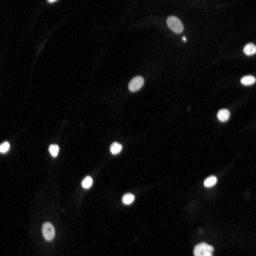

It crops to 4 masks with size (128, 128, 1)
cropped image and mask: 1


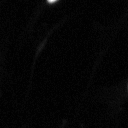

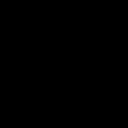

cropped image and mask: 2


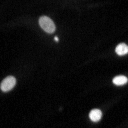

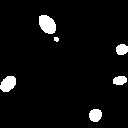

cropped image and mask: 3


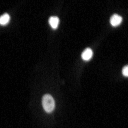

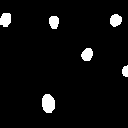

cropped image and mask: 4


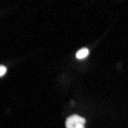

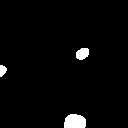

In [7]:
# display
train_set.display_crops() # without ix0 input, it will give a random index

## 4. Test the rejoin function

Image and mask from data set No. 384 with size (256, 256): 930f246a8e4ff273a72a6e4b3cf8e8caff94fca4eaf1dbe6f93ba37b8195c0a0
Original image


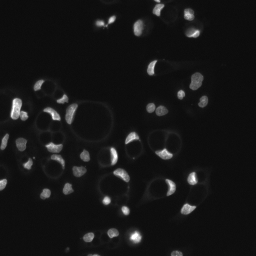

Processed image


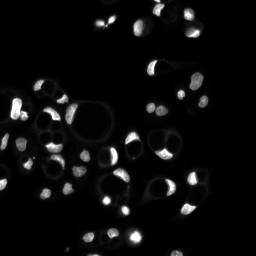

Original mask


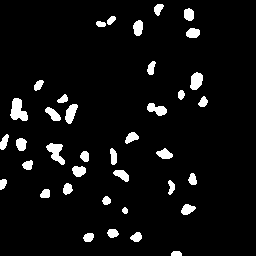

Rejoined mask


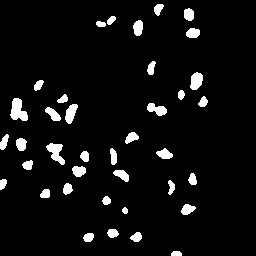

In [8]:
Y_pred_train = train_dict['Y']
train_set.rejoinMask(Y_pred_train)
train_set.display_rejoinmasks() # without ix0 input, it will give a random index

## 5. UNET model

### 5.1 Prepare data

In [9]:
train_set.list2array()
val_set.list2array()
X_train0, Y_train = train_set.data_dict['X_array'], train_set.data_dict['Y_array']
X_val0, Y_val = val_set.data_dict['X_array'], val_set.data_dict['Y_array']

 # gray scale only need one value, cause RGB values are the same. you can include all RGB data as well, but have to change the model input dimension as well.
X_train = X_train0[:,:,:,0]/255 # standardization
X_val = X_val0[:,:,:,0]/255
print(f'X_train shape:, {X_train.shape}; Y_train shape:, {Y_train.shape}')
print(f'X_val shape:, {X_val.shape}; Y_val shape:, {Y_val.shape}')

X_train shape:, (7315, 128, 128); Y_train shape:, (7315, 128, 128, 1)
X_val shape:, (812, 128, 128); Y_val shape:, (812, 128, 128, 1)


### 5.2 Model setup

In [10]:
# The convolation block 
def conv_block(m, dim, acti, bn, res, do=0):
    n = Conv2D(dim, 3, activation=acti, padding='same')(m)
    n = BatchNormalization()(n) if bn else n
    n = Dropout(do)(n) if do else n
    n = Conv2D(dim, 3, activation=acti, padding='same')(n)
    n = BatchNormalization()(n) if bn else n
    return Concatenate()([m, n]) if res else n

def level_block(m, dim, depth, inc, acti, do, bn, mp, up, res):
    if depth > 0:
        n = conv_block(m, dim, acti, bn, res)
        m = MaxPooling2D()(n) if mp else Conv2D(dim, 3, strides=2, padding='same')(n)
        m = level_block(m, int(inc*dim), depth-1, inc, acti, do, bn, mp, up, res)
        if up:
            m = UpSampling2D()(m)
            m = Conv2D(dim, 2, activation=acti, padding='same')(m)
        else:
            m = Conv2DTranspose(dim, 3, strides=2, activation=acti, padding='same')(m)
        n = Concatenate()([n, m])
        m = conv_block(n, dim, acti, bn, res)
    else:
        m = conv_block(m, dim, acti, bn, res, do)
    return m

def UNet(img_shape, out_ch=1, start_ch=64, depth=4, inc_rate=2., activation='relu', 
         dropout=0.5, batchnorm=False, maxpool=True, upconv=True, residual=False):
    i = Input(shape=img_shape)
    o = level_block(i, start_ch, depth, inc_rate, activation, dropout, batchnorm, maxpool, upconv, residual)
    o = Conv2D(out_ch, 1, activation='sigmoid')(o)
    return Model(inputs=i, outputs=o)

### 5.3 Parameters

In [11]:
epochs = 5
batch_size = 32
LR = 0.00025

early_stopping = EarlyStopping(patience=10, verbose=1)
model_checkpoint = ModelCheckpoint(f"{data_loc}/keras.model", save_best_only=True, verbose=1)
reduce_lr = ReduceLROnPlateau(factor=0.1, patience=5, min_lr=0.00001, verbose=1)

model = UNet((128,128,1),start_ch=16,depth=4,batchnorm=True,dropout=0)
model.compile(loss=diceloss, optimizer=Adam(learning_rate=LR), metrics=[mean_iou])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 1  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 16  160         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 batch_normalization (BatchNorm  (None, 128, 128, 16  64         ['conv2d[0][0]']                 
 alization)                     )                                                             

### 5.4 Training

In [12]:
history = model.fit(X_train, Y_train,
                    validation_data=[X_val, Y_val], 
                    epochs=epochs,
                    batch_size=batch_size,
                    #callbacks=[early_stopping, model_checkpoint, reduce_lr],
                    shuffle=True)

Epoch 1/5
229/229 [==============================] - 46s 110ms/step - loss: 0.3871 - mean_iou: 0.6166 - val_loss: 0.7976 - val_mean_iou: 0.1952
Epoch 2/5
229/229 [==============================] - 22s 97ms/step - loss: 0.2257 - mean_iou: 0.7410 - val_loss: 0.5260 - val_mean_iou: 0.4735
Epoch 3/5
229/229 [==============================] - 23s 100ms/step - loss: 0.1557 - mean_iou: 0.7936 - val_loss: 0.1969 - val_mean_iou: 0.7474
Epoch 4/5
229/229 [==============================] - 23s 99ms/step - loss: 0.1158 - mean_iou: 0.8224 - val_loss: 0.1909 - val_mean_iou: 0.7273
Epoch 5/5
229/229 [==============================] - 22s 97ms/step - loss: 0.1008 - mean_iou: 0.8299 - val_loss: 0.2231 - val_mean_iou: 0.7071


### 5.5 Model evaluation

Training set IoU: 0.8405
Training set Loss:0.115035

Validation set IoU: 0.7071
Validation set Loss:0.223064



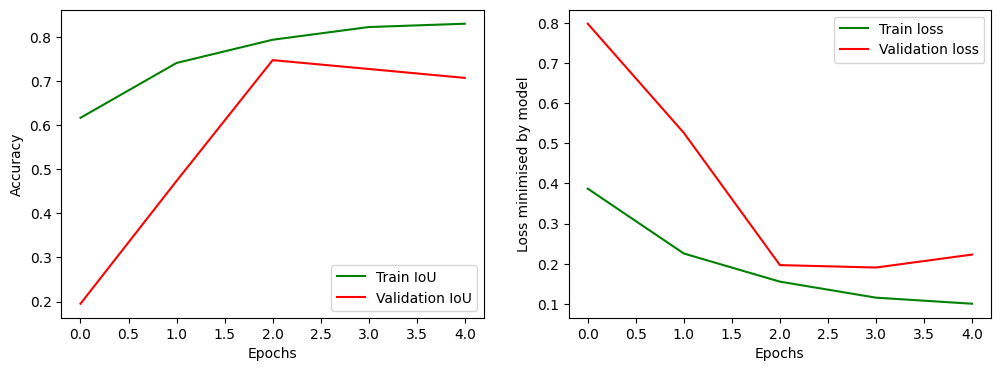

In [13]:
[train_loss, train_IoU] = model.evaluate(X_train, Y_train, verbose=0)
print("Training set IoU:{:7.4f}".format(train_IoU))
print("Training set Loss:{:7.6f}\n".format(train_loss))

[val_loss, val_IoU] = model.evaluate(X_val, Y_val, verbose=0)
print("Validation set IoU:{:7.4f}".format(val_IoU))
print("Validation set Loss:{:7.6f}\n".format(val_loss))

plot_history(history)

In [14]:
preds_train = model.predict(X_train, verbose=1)
preds_val = model.predict(X_val, verbose=1)

preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)

26/26 [==============================] - 1s 23ms/step


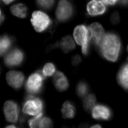

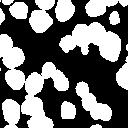

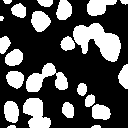

In [15]:
ix = random.randint(0, len(preds_val_t))
display(keras.preprocessing.image.array_to_img(X_val0[ix]*255))
display(keras.preprocessing.image.array_to_img(Y_val[ix]))
display(keras.preprocessing.image.array_to_img(preds_val_t[ix]))

### 5.6 Calculate IoU for Validation set

In [16]:
train_set.rejoinMask(preds_train)
val_set.rejoinMask(preds_val)

train_set.cal_iou()
print("Train set IoU:{:7.4f}".format(train_set.mean_iou))
val_set.cal_iou()
print("Validation set IoU:{:7.4f}".format(val_set.mean_iou))

Train set IoU: 0.8236
Validation set IoU: 0.7056


### 5.7 Test evaluation (to be updated)

In [ ]:
test_set = data_grinder(test_dict)
test_set.preprocessImages()
test_set.croporresizeImages(hasmask = False)
test_set.list2array()
X_test0 = test_set.data_dict['X_array']

X_test = X_test0[:,:,:,0]/255 # standardization

In [ ]:
preds_test = model.predict(X_test, verbose=1)
preds_test_t = (preds_test > 0.5).astype(np.uint8)
test_set.rejoinMask(preds_test)

1335/1335 [==============================] - 33s 25ms/step


In [ ]:
imageIDs = test_set.data_dict['imageIDs']
ix = random.randint(0, len(imageIDs) - 1)
display(test_set.data_dict['images'][ix])
display(test_set.data_dict['cal_masks'][ix])

## 6. Export to EXCEL